In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
!pip install nms
from nms import nms
import torch, torchvision
from zipfile import ZipFile
import csv
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
#importing the drive
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/sharedwithme/")

Mounted at /content/drive


In [ ]:
#start of jacobs code above is just the stuff from the facebook tutorial 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
data=[]

for filename in os.listdir('/content/drive/My Drive/415Group25/frames/frames/'):
    if filename.endswith("jpg"): 
        data.append(filename)

print("seq_001995.jpg" in data)
frames=[]
for image in data[:400]:
  frame=mpimg.imread('/content/drive/My Drive/415Group25/frames/frames/'+image)
  frames.append(frame)

True


In [ ]:
print(len(frames))
print(data[0:100])

400
['seq_001010.jpg', 'seq_000995.jpg', 'seq_000996.jpg', 'seq_001000.jpg', 'seq_000991.jpg', 'seq_001005.jpg', 'seq_001009.jpg', 'seq_001004.jpg', 'seq_000989.jpg', 'seq_001007.jpg', 'seq_000986.jpg', 'seq_000987.jpg', 'seq_000994.jpg', 'seq_001023.jpg', 'seq_001042.jpg', 'seq_001037.jpg', 'seq_001039.jpg', 'seq_001026.jpg', 'seq_001043.jpg', 'seq_001041.jpg', 'seq_001033.jpg', 'seq_001014.jpg', 'seq_001035.jpg', 'seq_001015.jpg', 'seq_001018.jpg', 'seq_001032.jpg', 'seq_001038.jpg', 'seq_001027.jpg', 'seq_001021.jpg', 'seq_001044.jpg', 'seq_001022.jpg', 'seq_001036.jpg', 'seq_001020.jpg', 'seq_001031.jpg', 'seq_001025.jpg', 'seq_001017.jpg', 'seq_001024.jpg', 'seq_001029.jpg', 'seq_001016.jpg', 'seq_001028.jpg', 'seq_001030.jpg', 'seq_001034.jpg', 'seq_001046.jpg', 'seq_001019.jpg', 'seq_001040.jpg', 'seq_001045.jpg', 'seq_001058.jpg', 'seq_001051.jpg', 'seq_001048.jpg', 'seq_001056.jpg', 'seq_001067.jpg', 'seq_001074.jpg', 'seq_001061.jpg', 'seq_001078.jpg', 'seq_001080.jpg', 'seq_

In [ ]:
im=frames[100] #picking one image to test on 

#facebook tutorial!!
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #original 
#cfg.merge_from_file(model_zoo.get_config_file("COCO-PersonKeypointDetection/keypoint_rcnn_R_50_FPN_3x.yaml"))


cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well


cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PersonKeypointDetection/keypoint_rcnn_R_50_FPN_3x.yaml")


predictor = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:02, 73.2MB/s]                           


In [ ]:
# Helper function to eliminate randomly generated negative examples which are intersecting with people
def intersect(box, window): 
  box=box.tensor.tolist()[0]
  dx = min(box[2], window[2]) - max(box[0], window[0])
  dy = min(box[3], window[3]) - max(box[1], window[1])
  if (dx>=0) and (dy>=0):
    return True

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


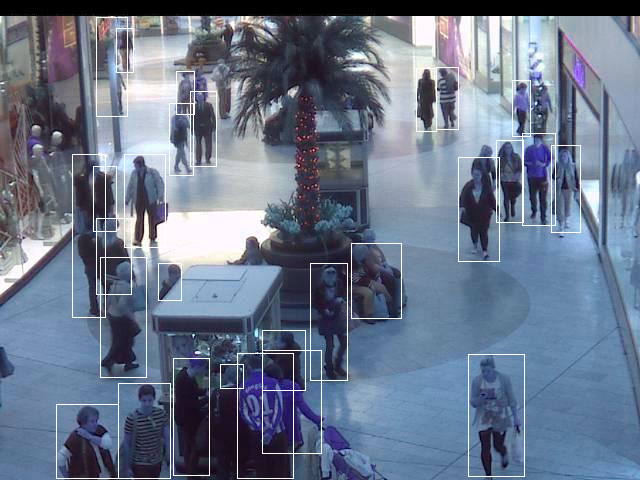

28


In [ ]:
## function to do part 1 
# Part 1 of project
# uses predictor of from previous code boxes
# maybe there is some way to use GPU accelertion to do it faster than I did it here??
# right now i have no code for removing duplicate deterctions because i have not seen any so far 
# uses facebook Detectron2 faster RCNN
def count_people(image):
  image=np.copy(image)
  outputs = predictor(image)
  new_pred_classes=[]
  new_pred_boxes=[]
  #print(outputs["instances"].pred_classes)
  for i in range (0, len(outputs["instances"].pred_classes)):
    if outputs["instances"].pred_classes[i]==0:
      new_pred_classes.append(outputs["instances"].pred_classes[i])
      new_pred_boxes.append(outputs["instances"].pred_boxes[i])

  new_image=np.copy(image)
  # Copy for avoiding rectangle in cropped images
  data_set_image = np.copy(image)

  people= new_pred_boxes

  # Store data set with positive and negative examples and their labels per frame
  train_data_set = []
  train_data_label = []

  #people= 
  for box in people:
    box=box.tensor.tolist()[0]
    # print(box)
    x1=int(box[0])
    y1=int(box[1])
    x2=int(box[2])
    y2=int(box[3])
    new_image = cv2.rectangle(image,(x1,y1),(x2,y2),(255,255,255),1)
    
    #Postive examples
    # Crop patches to obtain positive examples for the data set
    roi_color = data_set_image[y1:y2, x1:x2]
    train_data_set.append(roi_color)
    train_data_label.append ("Person")

    # For Debug - can be deleted
    #cv2_imshow(roi_color)

  #Negative examples
  # Number of negative examples should be same with the number of positive examples
  max_length = len(train_data_set) * 2
  while (len(train_data_set) < max_length):
    height, width = image.shape[0:2]
    x1 = np.random.randint(0,width-50)
    y1 = np.random.randint(0,height-100)
    x2 = x1 + 50
    y2 = y1 + 100
    #Random patch with size (50,100) is generated
    random_window = data_set_image[y1:y2, x1:x2]
    for box in people:
      #Check if the generated patch contains people
      contains_people = intersect(box, [x1,y1,x2,y2])
      if(contains_people == True):
        break
    train_data_set.append(random_window)
    train_data_label.append("Other")
    #Shuffle the obtained data set to prevent SVM from assigning false weights to labels
    train_data_set, train_data_label = shuffle(train_data_set, train_data_label)
    
    # For Debug - can be deleted
    # cv2_imshow(random_window)
    # print(" ")

  return (len(people), new_image, train_data_set, train_data_label)


number_people, boxed_image, data_set, data_label= count_people(frames[10])
cv2_imshow(boxed_image)
print(number_people)
# print(len(data_set))
# print(data_set)
# print(len(data_label))
# print(data_label)

## Person Classification Using SVM Classifiers

##Importing the entire dataset (original cell imports only 400 frames)

In [ ]:
with ZipFile('frames.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
data = []
for filename in os.listdir('/content/frames'):
  data.append(filename)

data = sorted(data)

frames=[]
for image in data: 
  frame=mpimg.imread('/content/frames/'+image)
  frames.append(frame)

2000


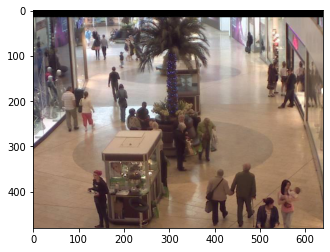

In [ ]:
plt.imshow(frames[0])
print(len(frames))

##Prep the data for training

In [ ]:
# create the dataset from all of the frames
training_dataset = []
training_labels = []
for frame in frames:
  numPeople, boxedImage, dataset, dataLabel = count_people(frame)
  for data in dataset:
    training_dataset.append(data)
  for label in dataLabel:
    training_labels.append(label)

In [ ]:
# method to get HOG descriptors of the dataset
def hog_features(images, image_size=(25, 50), cell_size=(5, 10), bins=4):
  features = []
  hog = cv2.HOGDescriptor(image_size, cell_size, cell_size, cell_size, bins)
  for image in images:
    image = cv2.resize(image, image_size, cv2.INTER_AREA)
    feature = hog.compute(cv2.convertScaleAbs(image))
    features.append(feature.reshape(1, -1))
  return features

##Training the svm

In [ ]:
# import SVM
from sklearn import svm

# instantiate an SVM classifier
person_classifier = svm.LinearSVC(C=10, max_iter=1000)

In [ ]:
# get HoG features
dataset_features = np.vstack(hog_features(training_dataset))

# train the classifier
person_classifier.fit(dataset_features, training_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

##Defining the sliding window function

In [ ]:
# define sliding window generator
def sliding_window(image, step_size, window_size):
  # slide a window across the image
  for height in range(0, image.shape[0], step_size):
    for width in range(0, image.shape[1], step_size):
      # yield the current window
      yield (height, width, image[height:height+window_size[0], width:width+window_size[1]])


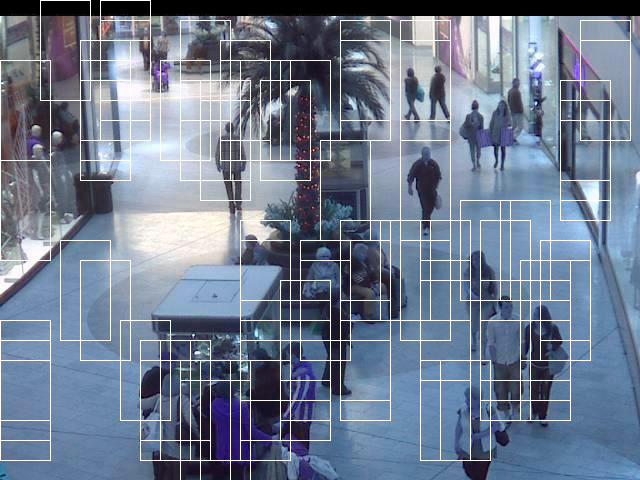

In [ ]:
step_size = 20
row_size = 100
col_size = 50
# test_frames : list of windows extracted from one frame using the sliding window
test_frames = []
# test_frame_coords : list of window and coordinates pairs to be able to draw the rectangles
test_frame_coords = []

for height, width, window in sliding_window(frames[100], step_size, (row_size, col_size)):
  if window.shape[0] != row_size or window.shape[1] != col_size:
    continue
  test_frames.append(window)
  test_frame_coords.append([(height, width), window])


test_frames_features = np.vstack(hog_features(test_frames))

# detect people in one frame
# np array with labels
predictions = person_classifier.predict(test_frames_features)
confidence_scores = person_classifier.decision_function(test_frames_features)

# detections : dictionary with key being the label and value being the coordinate and window pair
detections = zip(predictions, test_frame_coords, confidence_scores)

test_image = frames[100].copy()
# detected_boxes : the windows that are labeled as 'Person'
detected_boxes = []
detected_boxes_coord = []
conf_scores = []
for label, window, conf_score in detections:
  if label == 'Person':
    detected_boxes.append(window[1])
    detected_boxes_coord.append((window[0][1], window[0][0], window[1].shape[1], window[1].shape[0]))
    conf_scores.append(conf_score)
    test_image = cv2.rectangle(test_image, (window[0][1], window[0][0]), (window[0][1] + window[1].shape[1], window[0][0] + window[1].shape[0]), (255, 255, 255), 1)

cv2_imshow(test_image)

##Using non-maximum suppression to reduce duplicates

Num people detected: 79
(480, 640, 3)
Num people detected following nms: 32


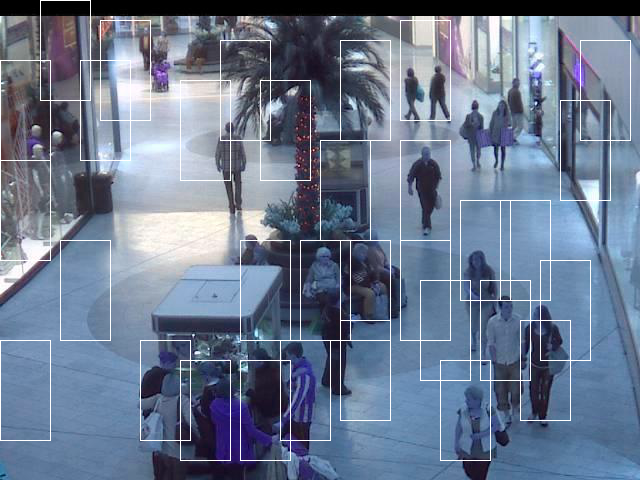

In [ ]:
print("Num people detected: "+str(len(detected_boxes)))

print(str(frames[100].shape))

indices = nms.boxes(detected_boxes_coord, conf_scores)
print("Num people detected following nms: "+str(len(indices)))

nms_test_image = frames[100].copy()

for i in indices:
  nms_test_image = cv2.rectangle(nms_test_image, (detected_boxes_coord[i][0], detected_boxes_coord[i][1]), (detected_boxes_coord[i][0] + detected_boxes_coord[i][2], detected_boxes_coord[i][1] + detected_boxes_coord[i][3]), (255, 255, 255), 1)

cv2_imshow(nms_test_image)

#Running all the frames


In [ ]:
count = []
for i in range(len(frames)):
  test_frames = []
  # test_frame_coords : list of window and coordinates pairs to be able to draw the rectangles
  test_frame_coords = []
  for height, width, window in sliding_window(frames[i], 35, (100, 50)):
    if window.shape[0] != 100 or window.shape[1] != 50:
      continue
    test_frames.append(window)
    test_frame_coords.append([(height, width), window])

  test_frames_features = np.vstack(hog_features(test_frames))

  # detect people in one frame
  # np array with labels
  predictions = person_classifier.predict(test_frames_features)
  confidence_scores = person_classifier.decision_function(test_frames_features)

  detections = zip(predictions, test_frame_coords, confidence_scores)


  # detected_boxes : the windows that are labeled as 'Person'
  detected_boxes_coord = []
  conf_scores = []
  for label, window, conf_score in detections:
    if label == 'Person':
      detected_boxes_coord.append((window[0][1], window[0][0], window[1].shape[1], window[1].shape[0]))
      conf_scores.append(conf_score)

  indices = nms.boxes(detected_boxes_coord, conf_scores)

  count.append(len(indices))

In [ ]:
print(len(count))

2000


#Writing the outputs

Sample1.csv --> C=10, step = 20, row = 100, col = 50

sample2.csv --> c = 1, step = 30, row = 100, col = 50

sample3 --> c = 4, step = 35, row = 100, col = 50

sample4 --> C = 10, step = 25, row = 100, col = 50

In [ ]:
#Write the predicted labels to a csv file
with open('sample.csv', mode='w') as csv_file:
  fieldnames = ['id', 'count']
  writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
  writer.writeheader()

  #Just need to set up the length
  for i in range(len(count)):
    #Need to add our predication to stringLabel
    stringLabel = str(count[i])
    stringId = str(i+1)
    writer.writerow({'id': stringId, 'count': stringLabel}) 

## Intersection over Union

In [ ]:
# get ground truth values for frame 100
output = predictor(frames[1])
ground_truth = []
# get the boxes of detected people to work with their coordinates
for i in range (0, len(output["instances"].pred_classes)):
  if output["instances"].pred_classes[i] == 0:
    box = output["instances"].pred_boxes[i].tensor.tolist()[0]
    ground_truth.append(box)
  
# get detected boxes for frame 100
predicted_boxes = []
for i in indices:
  predicted_boxes.append(detected_boxes_coord[i])

In [ ]:
# find intersection function
# box1 = box from ground_truth array
# box2 = box from test_frame_coords array
def is_overlapping(box1, box2):
  # get the coordinates of the top left and bottom right corners
  xmin1 = box1[0]
  xmax1 = box1[2]
  ymin1 = box1[1]
  ymax1 = box1[3]
  xmin2 = box2[0]
  xmax2 = box2[0] + box2[2]
  ymin2 = box2[1]
  ymax2 = box2[1] + box2[3]
  # determine if there are intersections in the x and y axes
  if ((xmax1 >= xmin2) and (xmax2 >= xmin1) and (ymax1 >= ymin2) and (ymax2 >= ymin1)):
    return True
  return False

In [ ]:
def find_intersects(ground_boxes, boxes):
  intersections = []
  for box in boxes:
    for ground_box in ground_boxes:
      if is_overlapping(ground_box, box):
        xintersect1 = max(ground_box[0], box[0])
        xintersect2 = min(ground_box[2], (box[0] + box[2]))
        yintersect1 = max(ground_box[1], box[1])
        yintersect2 = min(ground_box[3], (box[1] + box[3]))
        intersection = [xintersect1, yintersect1, xintersect2, yintersect2]
        intersections.append(intersection)
  return intersections

In [ ]:
def intersection_over_union(ground_boxes, boxes, intersections):
  area_ground_boxes = 0
  area_boxes = 0
  area_intersections = 0
  for ground_box in ground_boxes:
    area = (ground_box[2] - ground_box[0] + 1) * (ground_box[3] - ground_box[1] + 1)
    area_ground_boxes += area
  # our method returns boxes that have the same height and width
  area_boxes = len(boxes) * boxes[0][2]* boxes[0][3]
  if intersections is not None:
    for intersection in intersections:
      area = (intersection[2] - intersection[0] + 1) * (intersection[3] - intersection[1] + 1)
      area_intersections += area
  iou = area_intersections / (area_boxes + area_ground_boxes - area_intersections)
  return iou

In [ ]:
intersections = find_intersects(ground_truth, predicted_boxes)
iou = intersection_over_union(ground_truth, predicted_boxes, intersections)
print(iou)

0.0510216430062589
